In [1]:
import signac as sg
import numpy as np
from matplotlib import pyplot as plt
from scipy.special import gamma

In [2]:
project = sg.get_project()

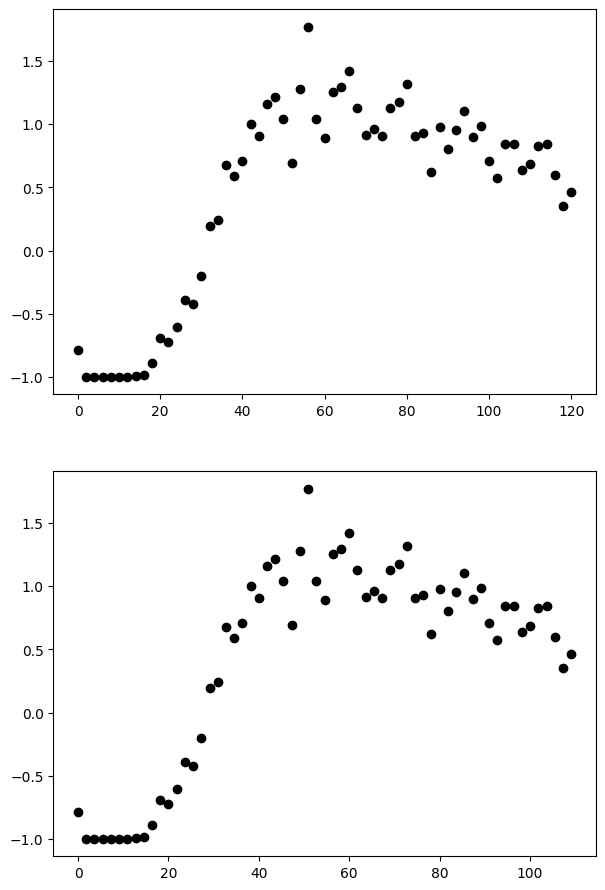

In [3]:
fig, axs = plt.subplots(2, 1, figsize=(7,11))
c = 1.42
# for job in project.find_jobs({'fire_prob': 0.17}):
for job in project:
    with job.data as data:
        N_tot_vec = np.array(data['N_tot_vec'])
        final_approx_vec = np.mean(N_tot_vec[:,-20:], axis=1)
        # final_approx = np.mean(final_approx_vec)
        init = N_tot_vec[0,0]
        # y = np.mean(final_approx_vec) / init
        err = np.std(final_approx_vec/init, ddof=1)
        diff_vec = final_approx_vec - init
        y_vec = diff_vec / init
        y = np.mean(y_vec)
        err = np.std(y_vec, ddof=1)
        axs[0].scatter(job.sp.weibull_b, y, color='k')
        # axs[0].errorbar(job.sp.fire_prob, y, yerr=err, color='k', fmt='o')
        # axs[0].set_ylim(-0.5, 6)
        fri = job.sp.weibull_b * gamma(1+1/c)
        axs[1].scatter(fri, y, color='k')
        # axs[1].errorbar(fri, y, yerr=err, color='k', fmt='o')

(0.0, 20.0)

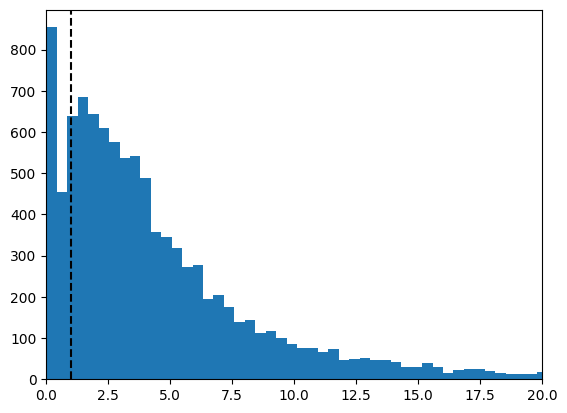

In [82]:
plt.hist(final_approx_vec/init, bins=400);
plt.axvline(1, ls='--', c='k')
plt.xlim(0,20)

In [42]:
for job in project.find_jobs({'weibull_b': 66}):
    with job.data as data:
        N_tot_vec = np.array(data['N_tot_vec'])
        final_approx_vec = np.mean(N_tot_vec[:,-20:], axis=1)
        y_vec = final_approx_vec
        census_t = np.array(data['census_t'])
        N_tot_mean = N_tot_vec.mean(axis=0)

[1.37920589e+05 1.31297312e-02]
200841332210706.78


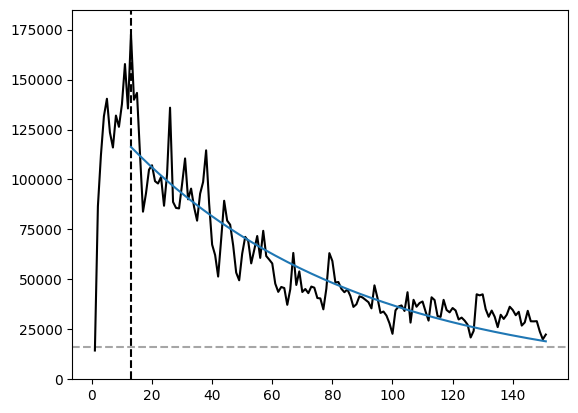

In [45]:
# Replica averaged lambda
from scipy.optimize import curve_fit

max_i = np.nonzero(N_tot_mean == max(N_tot_mean))[0][0]
# max_i = 40

# sim_mort = np.ones_like(N_tot_mean) * np.nan
# delta_t = 1
# for i in range(len(N_tot_mean)-1):
#     diff_per_N = (N_tot_mean[i] - N_tot_mean[i+1]) / N_tot_mean[i]
#     mort = diff_per_N / delta_t
#     if mort > 0:
#         sim_mort[i] = mort

# def exp(x, a, b, c):
    # return a * np.exp(-b * x) + c
# p0 = [300000, 0.035, 30000]
# popt, pcov = curve_fit(exp, census_t[max_i:], N_tot_mean[max_i:], x_scale=[1000,0.01,1000], method='trf', bounds=(0, [600000., 10., 600000]), p0=p0)
# popt, pcov = curve_fit(exp, census_t[max_i:], N_tot_mean[max_i:], x_scale=[1000,0.01,1000], method='trf', bounds=([10_000, 0, 10_000], [600000., 1., 600000]))
def exp(x, a, b):
    return a * np.exp(-b * x)
# p0 = [300000, 0.035]
popt, pcov = curve_fit(exp, census_t[max_i:], N_tot_mean[max_i:], x_scale=[1000,0.01], method='trf', bounds=([100, 0], [600000., 1.]))
print(popt)
print(np.linalg.cond(pcov))

plt.plot(census_t, N_tot_mean, c='k')
K_adult = 16000
plt.axhline(K_adult, ls='--', c='k', alpha=0.35)
plt.axvline(census_t[max_i], ls='--', c='k')
# plt.plot(census_t[max_i:], exp(census_t[max_i:], popt[0], popt[1], popt[2]))
plt.plot(census_t[max_i:], exp(census_t[max_i:], popt[0], popt[1]))
# plt.plot(census_t[max_i:], exp(census_t[max_i:], 5000000, 0.4))
plt.ylim(0,185000)
plt.show()
# plt.plot(census_t, sim_mort)

In [44]:
N_tot_vec = np.load('N_tot_vec.npy')
N_tot_mean = N_tot_vec.mean(axis=0)
census_t = np.load('census_t.npy')
delta_t = census_t[1] - census_t[0]

[0.00045813]
1.0


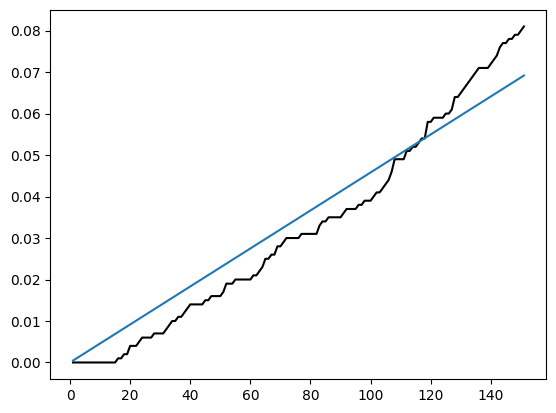

In [34]:
# Fraction extirpated over time
frac_extirpated = [sum(N_tot_vec[:,t_i]==0)/N_tot_vec.shape[0] for t_i in range(N_tot_vec.shape[1])]
max_i = 0
def line(x, m):
    return m*x
popt, pcov = curve_fit(line, census_t[max_i:], frac_extirpated[max_i:])
print(popt)
print(np.linalg.cond(pcov))
plt.plot(census_t, frac_extirpated, c='k')
# plt.plot(census_t[max_i:], line(census_t[max_i:], popt[0], popt[1]))
plt.plot(census_t[max_i:], line(census_t[max_i:], popt[0]))
# plt.axhline(1, ls='--', c='k', alpha=0.5)

(-480.0, 24000.0)

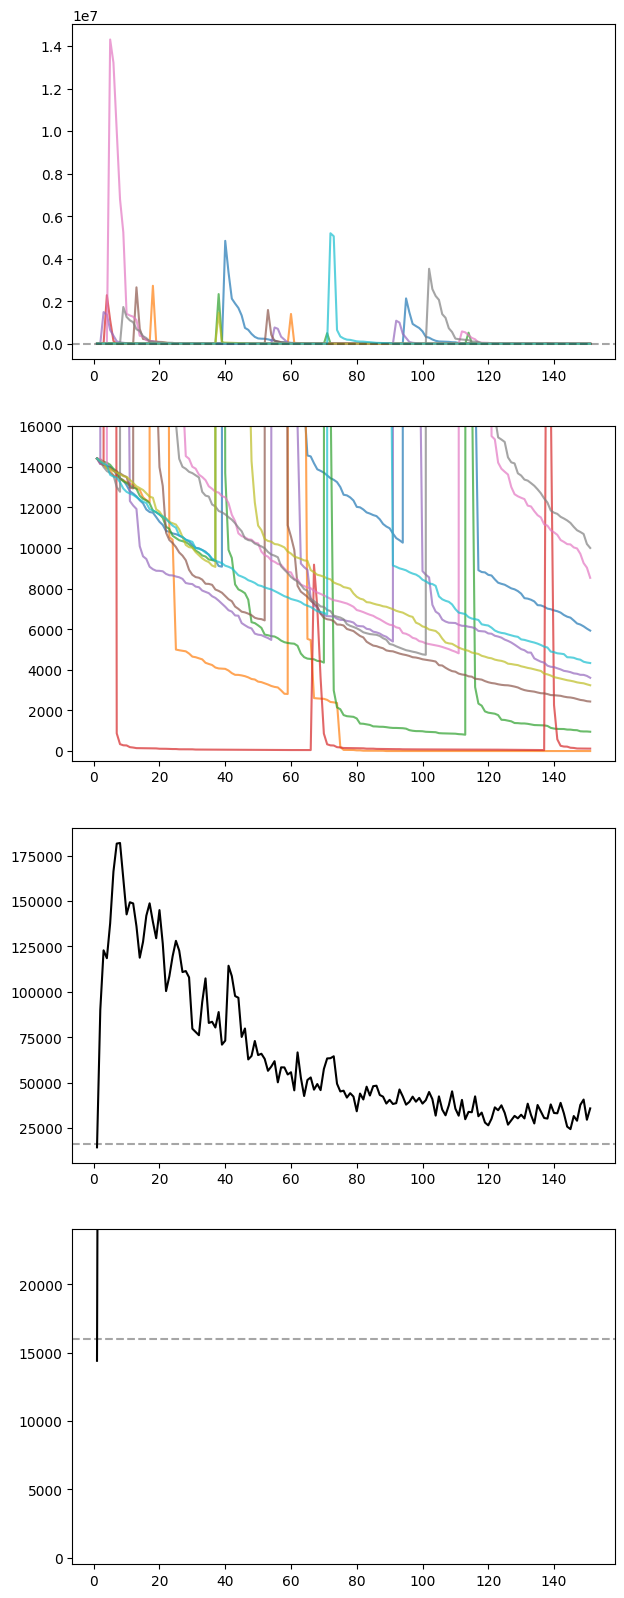

In [35]:
fig, axs = plt.subplots(4, 1, figsize=(7,20))
for N in N_tot_vec[::int(len(N_tot_vec)/10)]:
    axs[0].plot(census_t,N, alpha=0.7)
    axs[1].plot(census_t,N, alpha=0.7)
K_adult = 16000
axs[0].axhline(K_adult, ls='--', c='k', alpha=0.35)
axs[1].set_ylim(-0.03*K_adult,K_adult)
#print(len(model.N_tot_vec.mean(axis=0)))
axs[2].plot(census_t, N_tot_vec.mean(axis=0), c='k')
axs[2].axhline(K_adult, ls='--', c='k', alpha=0.35)
axs[3].plot(census_t, N_tot_vec.mean(axis=0), c='k')
axs[3].axhline(K_adult, ls='--', c='k', alpha=0.35)
axs[3].set_ylim(-0.03*K_adult,1.5*K_adult)

(-100.0, 5000.0)

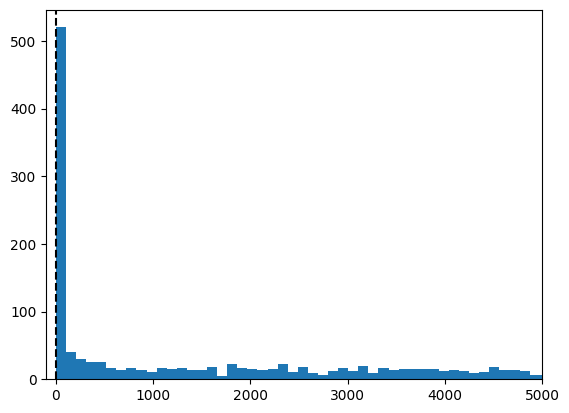

In [241]:
hist = plt.hist(y_vec, bins=10000);
# hist = plt.hist(y_vec, bins=100);
plt.axvline(0, ls='--', c='k')
plt.xlim(-100,5000)